In [247]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

charging = pd.read_csv("./charging_cleaned.csv", encoding = "ISO-8859-1")
weather = pd.read_csv("./weather_cleaned.csv", encoding = "ISO-8859-1")

In [248]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

<h1> Task 2 </h1>

<h2> Task 2 a.) - Showing daily demand

2 approaches for daily demand: 

1. show every single hour
2. divide day in morning, noon ect.

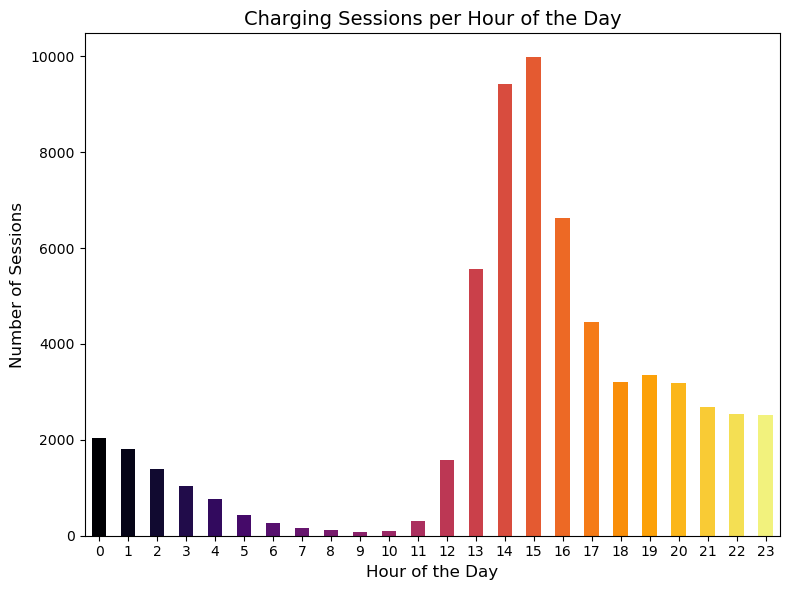

In [249]:
#first approach
charging['hour_of_day'] = charging['connectionTime'].dt.hour

cmap = plt.get_cmap("inferno")  # You can change this to any other colormap like 'plasma', 'inferno', etc.
colors = [cmap(i / 24) for i in range(24)]

plt.figure(figsize=(8, 6))
sessions_per_hour = charging.groupby('hour_of_day').size()

sessions_per_hour.plot(kind='bar', color=colors)

plt.xticks(range(0, 24), rotation=0)
plt.title('Charging Sessions per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()



<h1>Idea: Show 2 bar charts per hour next to each other -> one for disconnectTime and one for connectTime <h1>

In [250]:
import pandas as pd

# Ensure connectionTime is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Extract the weekday from the connection time
charging['weekday'] = charging['connectionTime'].dt.dayofweek

# Filter for sessions that start on weekends (Saturday=5, Sunday=6)
weekend_sessions = charging[charging['weekday'] >= 5]

# Count the number of sessions per site
weekend_sessions_per_site = weekend_sessions.groupby('siteID').size()

# Print the aggregated results
print(weekend_sessions_per_site)



siteID
1     983
2    4988
dtype: int64


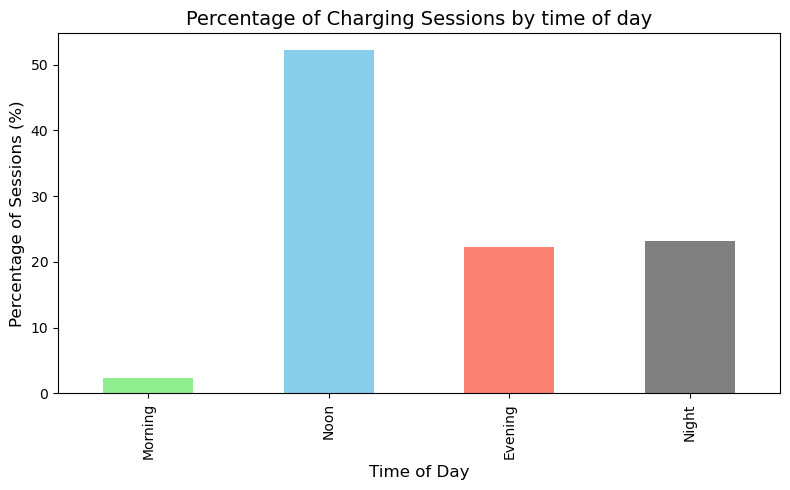

In [251]:
def classify_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

charging['time_of_day'] = charging['connectionTime'].dt.hour.apply(classify_time_of_day)

# Number of charging sessions for each time of day
time_of_day_counts = charging['time_of_day'].value_counts().reindex(['Morning', 'Noon', 'Evening', 'Night'])

# Calculate percentage of each category
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# create bar chart
plt.figure(figsize=(8, 5))  
time_of_day_percentage.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon', 'gray'])

plt.title('Percentage of Charging Sessions by time of day', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Percentage of Sessions (%)', fontsize=12)
plt.tight_layout()
plt.show()


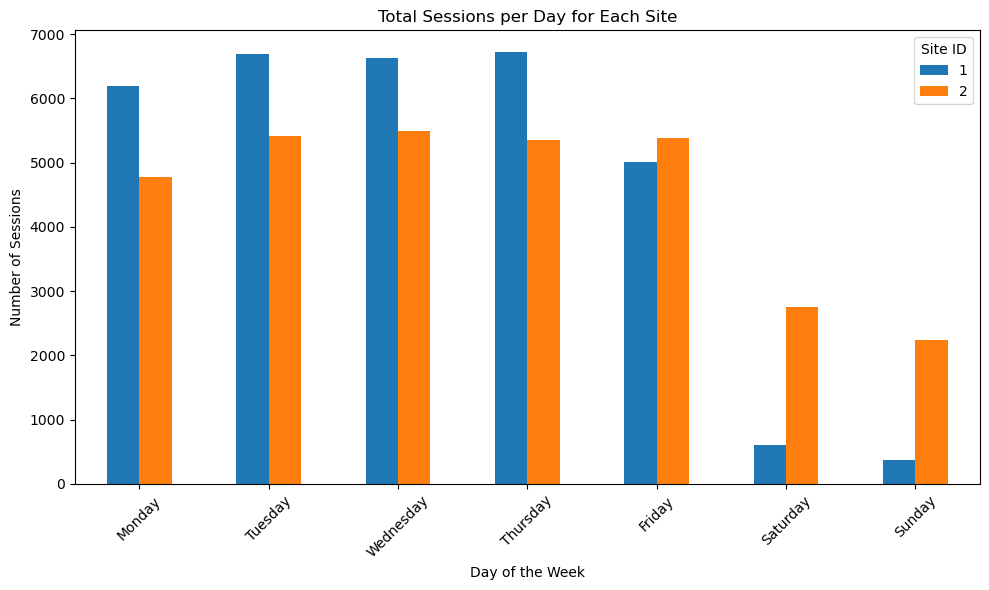

In [252]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure connectionTime is in datetime format
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

# Extract the weekday and site information
charging['weekday'] = charging['connectionTime'].dt.dayofweek  # 0=Monday, 6=Sunday

# Group by site and weekday, and count the number of sessions
sessions_per_day_site = charging.groupby(['siteID', 'weekday']).size().reset_index(name='session_count')

# Pivot the data for better visualization
sessions_pivot = sessions_per_day_site.pivot(index='weekday', columns='siteID', values='session_count').fillna(0)

# Plotting
sessions_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Total Sessions per Day for Each Site')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sessions')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.legend(title='Site ID')
plt.tight_layout()
plt.show()


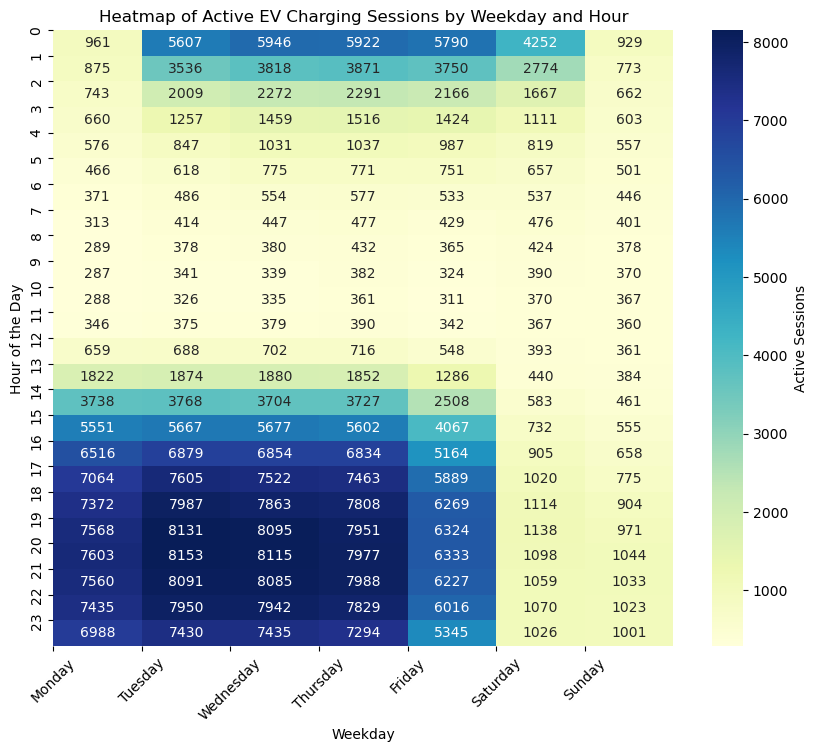

In [253]:
charging['weekday'] = charging['connectionTime'].dt.dayofweek
charging['hour_of_day'] = charging['connectionTime'].dt.hour

# Create a DataFrame of all hours within each session
charging['hourly_range'] = charging.apply(
    lambda row: pd.date_range(
        start=row['connectionTime'].floor('h'),
        end=row['disconnectTime'].ceil('h') - pd.Timedelta(hours=1),
        freq='h'
    ), axis=1
)

# Expand the hourly ranges into individual rows
expanded = charging.explode('hourly_range')

# Extract weekday and hour of day
expanded['weekday'] = expanded['hourly_range'].dt.dayofweek
expanded['hour_of_day'] = expanded['hourly_range'].dt.hour

# Group by weekday and hour_of_day to count active sessions
summary = expanded.groupby(['weekday', 'hour_of_day']).size().reset_index(name='active_sessions')

# Pivot data for heatmap
heatmap_data = summary.pivot(index='hour_of_day', columns='weekday', values='active_sessions').fillna(0)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".0f", cbar_kws={'label': 'Active Sessions'})
plt.title("Heatmap of Active EV Charging Sessions by Weekday and Hour")
plt.xlabel("Weekday")
plt.ylabel("Hour of the Day")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.yticks(ticks=range(0, 24), labels=range(0, 24))
plt.show()

This heatmap shows the active charging sessions in correlation of hour of the day and weekday.
The active sessions are found by finding the sum of sessions
which have already started until this hour and are disconnected after the particular hour.

<h5>Interpretation</h5>

Regardless of the approach, we see that there is a **pattern in daily use**. In the early morning hours the demand is at its lowest and the demand increases as we reach Noon. The **peak time** of demand is the Noon time around 12pm to 6pm and in the evening from 6pm on the demand decreases linearly until the next day on 10am right before noon

<h2> Task 2 a.) - Showing weekly demand

The problem here is that 42% of the sessions start on one day and end in the next day or longer, so it isn't optimal to assign day belonging based on connection time

In [254]:
#count the percentage of sessions that go over multiple days
sessions_spanning_midnight = len(charging[charging['connectionTime'].dt.date != charging['disconnectTime'].dt.date])
percentage_spanning_midnight = (sessions_spanning_midnight / len(charging)) * 100

print(percentage_spanning_midnight)

42.60499182698353


<h4>Approach for showing weekly demand </h4>

The problem here is that some sessions might start at 23:59 and if we would only regard "connectionTime" for day belonging, some sessions which begin at 23:59 are assigned to this day which isn't accurate. 

My proposed soluton: for each row/session, compute the duration (disconnectTime-connectTime) and we assign the session to the day where the **majority of the charging duration** occured

Monday: 10555 sessions
Tuesday: 12094 sessions
Wednesday: 12037 sessions
Thursday: 12162 sessions
Friday: 10593 sessions
Saturday: 3556 sessions
Sunday: 2627 sessions


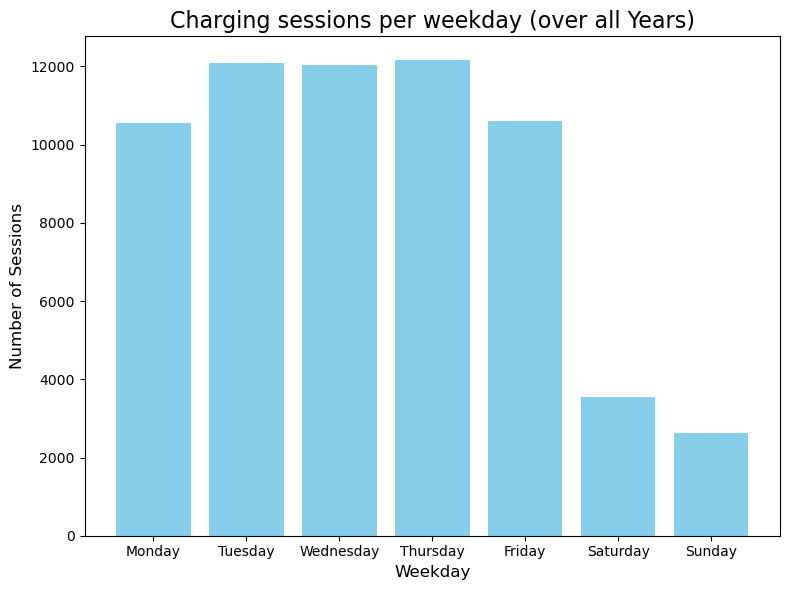

In [255]:
weekday_counts = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    # Calculate duration of particular session
    duration = disconnect_time - connection_time
    
    # Case 1: session is on the same day. if yes, we can stop here
    if connection_time.date() == disconnect_time.date():
        # Add to the weekday of the connection time
        weekday_counts[connection_time.strftime('%A')] += 1
    
    # Case 2: Session spanning multiple days
    else:
        # Split the duration into two parts:  
        # First part is from connetcion time to midnight of the same day
        # Second part is from midnight to disconnect time on the next day
        
        
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday_counts[connection_time.strftime('%A')] += 1
        else:
            weekday_counts[disconnect_time.strftime('%A')] += 1


for day, count in weekday_counts.items():
    print(f"{day}: {count} sessions")


plt.figure(figsize=(8, 6))
plt.bar(weekday_counts.keys(), weekday_counts.values(), color='skyblue')
plt.title('Charging sessions per weekday (over all Years)', fontsize=16)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

plt.tight_layout()
plt.show()


<h1>Idea: Create boxplot to show average weekday demand. -> charging session per weekday and compute mean/average </h1>

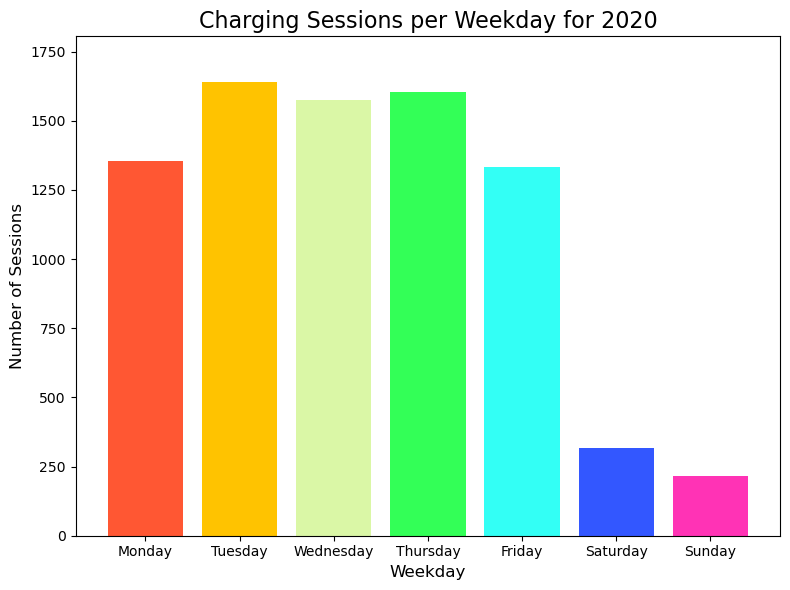

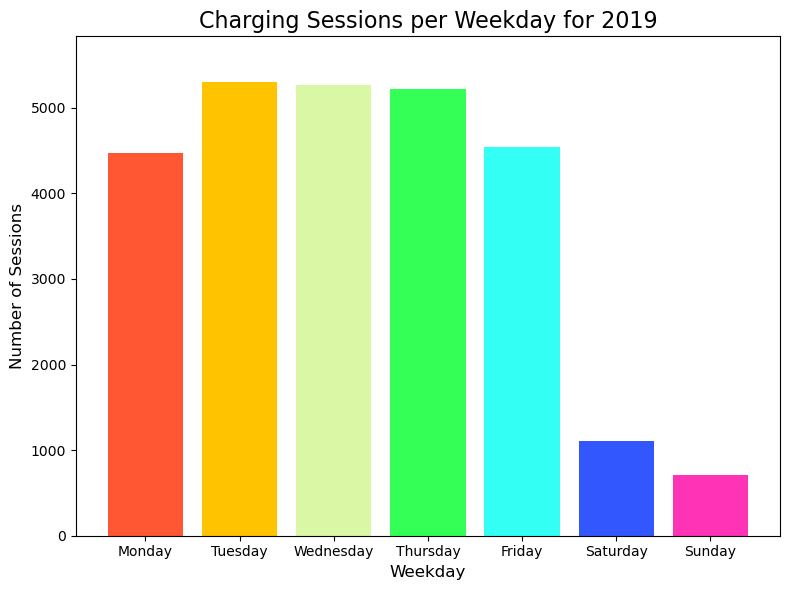

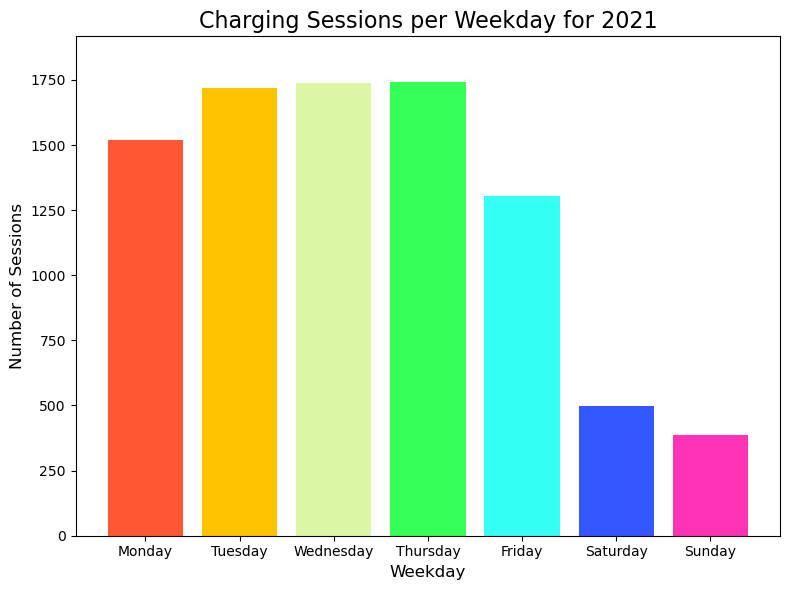

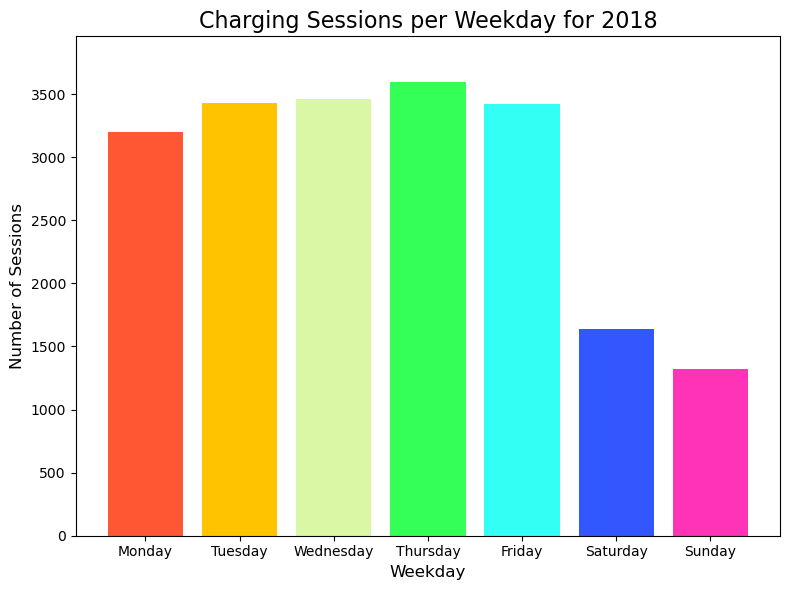

In [256]:
#grouping the weeks by year (just for testing). here wo would have to normalize

yearly_weekday_counts = {}

for index, row in charging.iterrows():
    connection_time = row['connectionTime']
    disconnect_time = row['disconnectTime']
    
    duration = disconnect_time - connection_time
    
    year = connection_time.year
    
    if year not in yearly_weekday_counts:
        yearly_weekday_counts[year] = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0, 'Sunday': 0}
    
    if connection_time.date() == disconnect_time.date():
        weekday = connection_time.strftime('%A')
        yearly_weekday_counts[year][weekday] += 1
    
    else:
        midnight_same_day = connection_time.replace(hour=23, minute=59, second=59)
        duration_first_day = midnight_same_day - connection_time
        midnight_on_next_day = disconnect_time.replace(hour=0, minute=0, second=0)
        duration_second_day = disconnect_time - midnight_on_next_day
        
        if duration_first_day > duration_second_day:
            weekday = connection_time.strftime('%A')
        else:
            weekday = disconnect_time.strftime('%A')
        
        yearly_weekday_counts[year][weekday] += 1

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors = ['#FF5733', '#FFC300', '#DAF7A6', '#33FF57', '#33FFF5', '#3357FF', '#FF33B5']


for year, counts in yearly_weekday_counts.items():
    plt.figure(figsize=(8, 6))
    plt.bar(weekdays, counts.values(), color=colors)    
    plt.title(f'Charging Sessions per Weekday for {year}', fontsize=16)
    plt.xlabel('Weekday', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)  
    plt.ylim(0, max(max(counts.values()) * 1.1, 25))  
    
    plt.tight_layout()
    plt.show()




Regardless of the which approach, we can clearly see that the **peak days are tuesday, wednesday and thursday.** On the weekend, demand isn't that hight. Intuitively, this makes sense as most people would use their E-Cars on weekdays.

**Interestingly, the proportion of sessions in year 2018 on the weekend were higher than in the next years**

<h1> Idea: Show site demand per year </h1>

<h2> Task 2 a.) - Showing season patterns

Proposed approaches: 
1. Divide year in summer, spring, winter and autumn and show numbers (for each year)
2. Show monthly number of sessions over the year
3. Show the number of sessions over the years(i.e. for each year)

Try approach 1 and 2


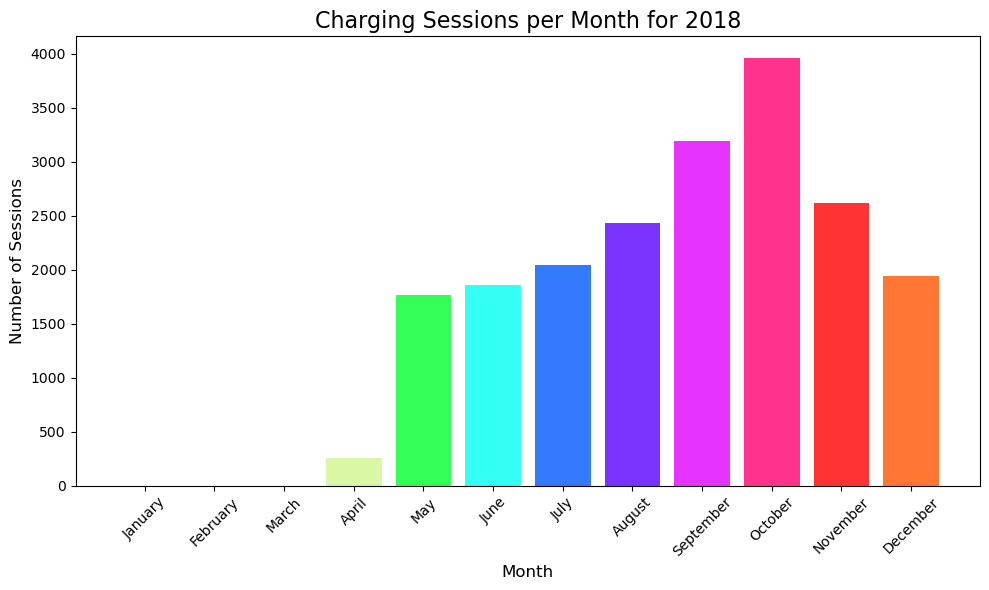

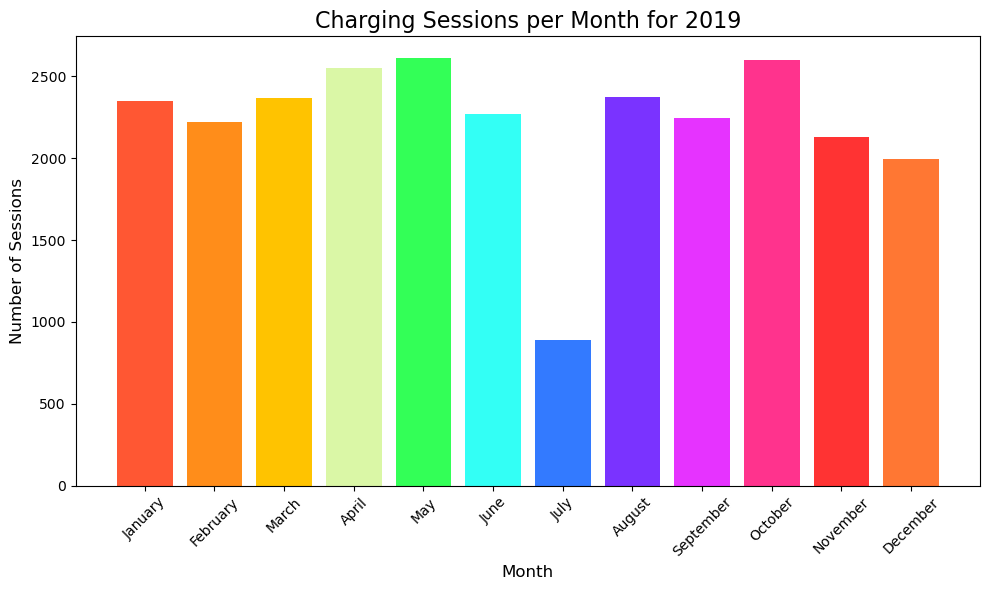

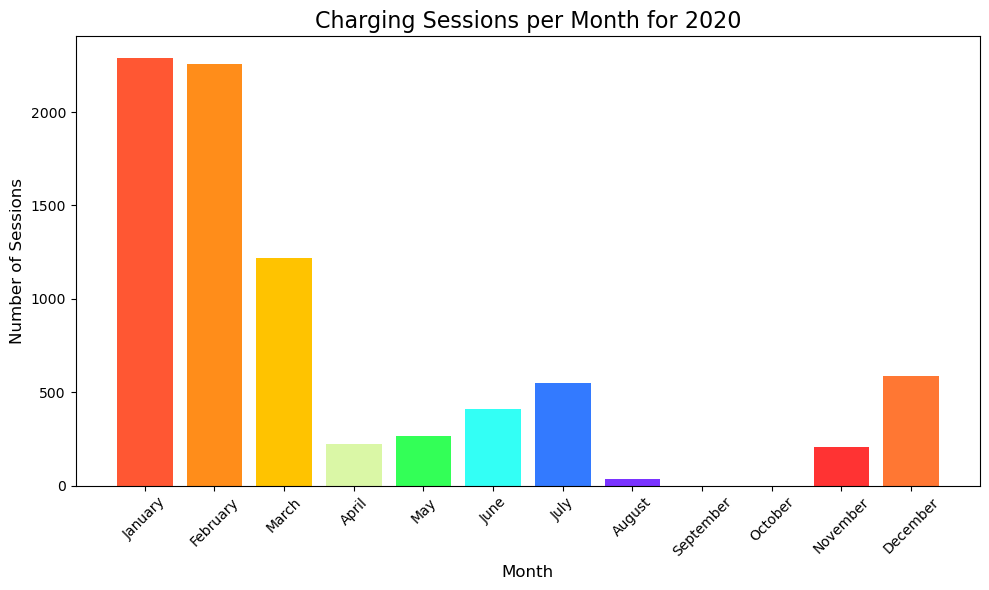

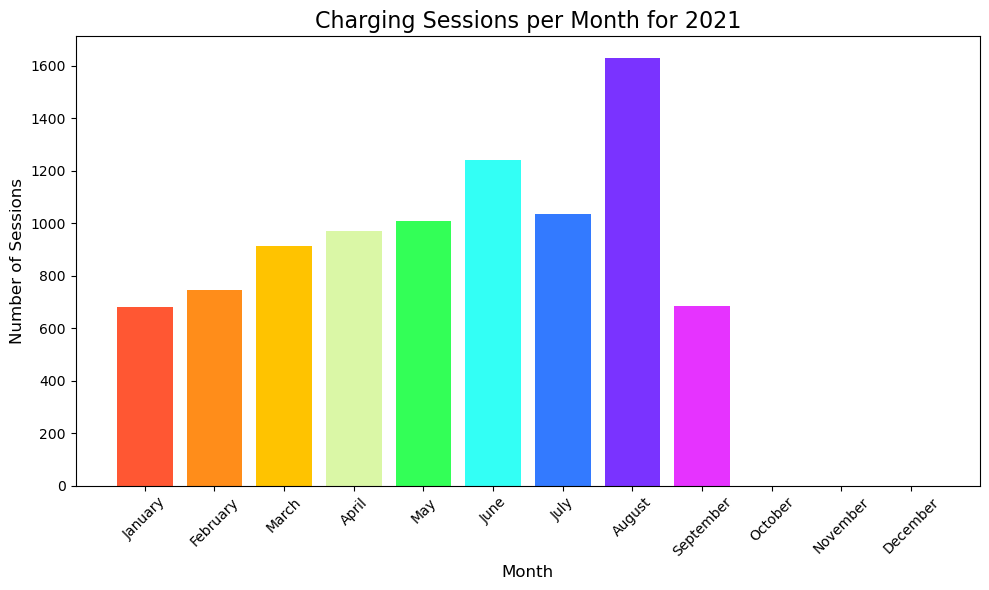

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar


# Approach 1
''''
def get_season(date):
    if (date.month == 12 and date.day >= 21) or (date.month <= 3 and date.month >= 1):
        return 'Winter'
    elif 3 <= date.month <= 5:
        return 'Spring'
    elif 6 <= date.month <= 8:
        return 'Summer'
    elif 9 <= date.month <= 11:
        return 'Fall'

charging['season'] = charging['connectionTime'].apply(get_season)
charging['year'] = charging['connectionTime'].dt.year
seasonal_trends = charging.groupby(['year', 'season']).size().unstack(fill_value=0)
seasonal_trends.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Seasonal charging sessions trends over the years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
'''







#approach 2
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])

charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

month_colors = [
    '#FF5733', '#FF8D1A', '#FFC300', '#DAF7A6', '#33FF57',
    '#33FFF5', '#337AFF', '#7A33FF', '#E633FF', '#FF338D',
    '#FF3333', '#FF7733'
]

for year, counts in yearly_monthly_counts.iterrows():
    plt.figure(figsize=(10, 6))
    months = [calendar.month_name[i] for i in range(1, 13)]
    plt.bar(months, counts, color=month_colors)
    
    plt.title(f'Charging Sessions per Month for {year}', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Sessions', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



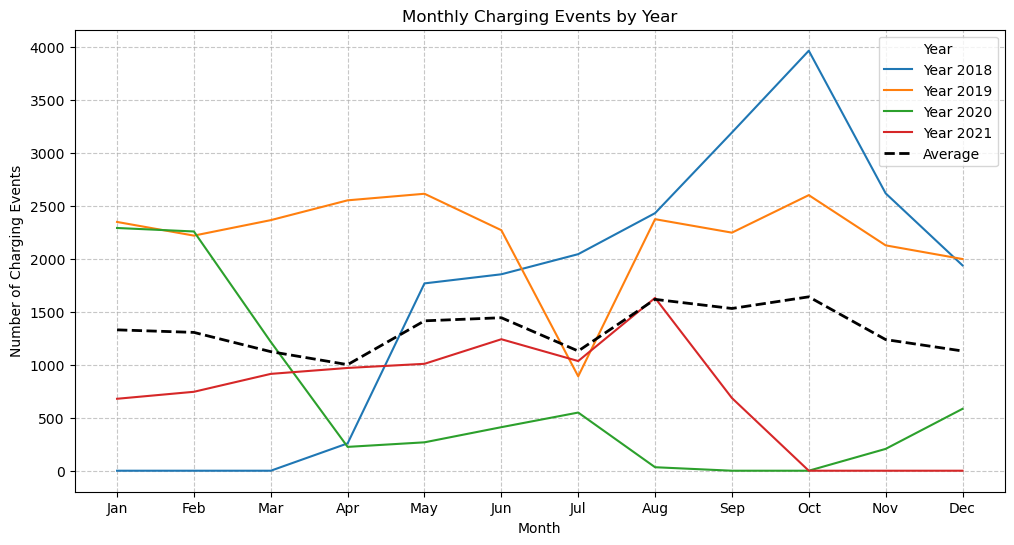

In [258]:
charging['year'] = charging['connectionTime'].dt.year
charging['month'] = charging['connectionTime'].dt.month

yearly_monthly_counts = charging.groupby(['year', 'month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

average_counts = yearly_monthly_counts.mean(axis=0)
plt.plot(average_counts.index, average_counts.values, label="Average", color='black', linestyle='--', linewidth=2)

# Add labels, title, and legend
plt.title("Monthly Charging Events by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# doneChargingTime vs disconnectTime

In [259]:
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
(charging['idle_time_minutes'] < 0).any()

True

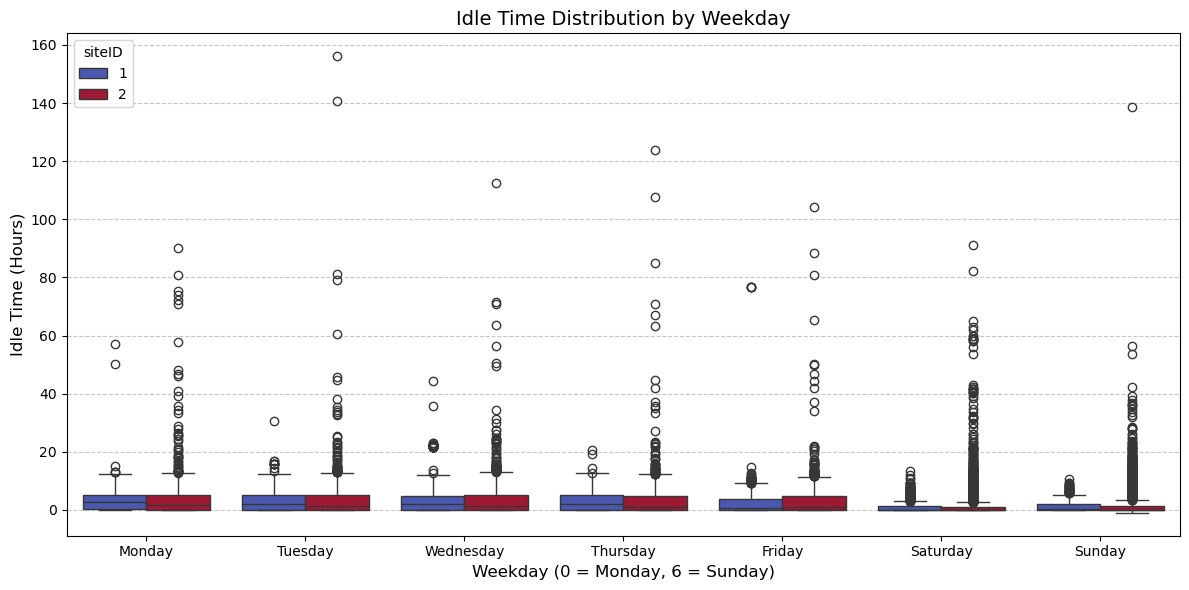

In [260]:
# Add a column for the weekday (0 = Monday, 6 = Sunday)
charging['weekday'] = charging['doneChargingTime'].dt.dayofweek

# Calculate idle time (in minutes)
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
charging['idle_time_hours'] = charging['idle_time_minutes'] / 60

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='idle_time_hours', palette='coolwarm', hue='siteID')

# Customize the plot
plt.title('Idle Time Distribution by Weekday', fontsize=14)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=12)
plt.ylabel('Idle Time (Hours)', fontsize=12)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

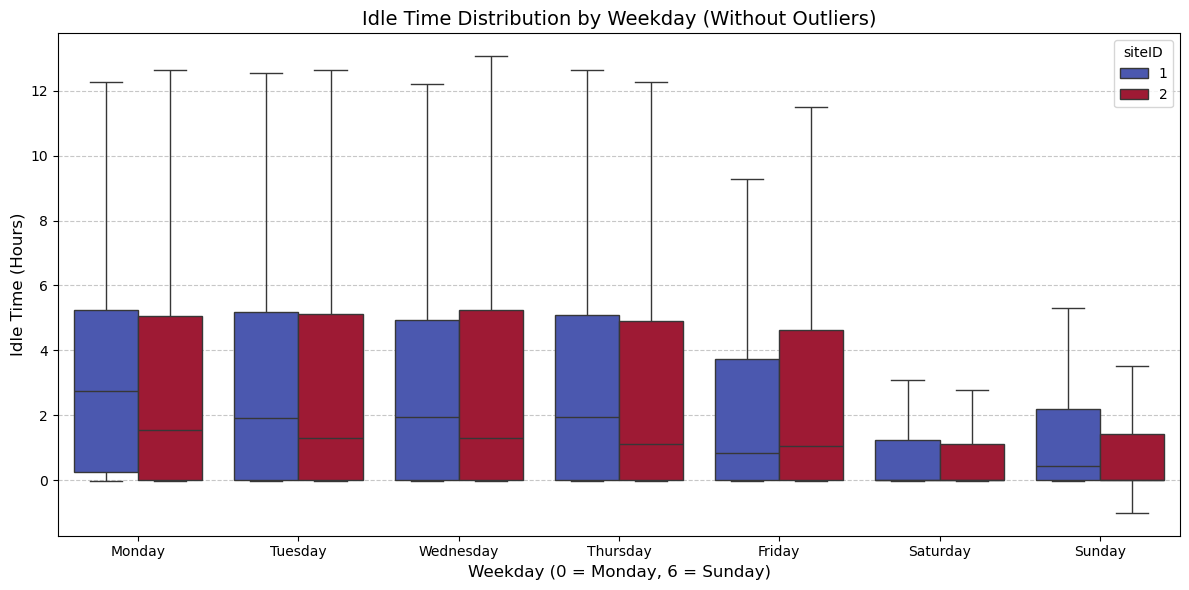

In [261]:
# Add a column for the weekday (0 = Monday, 6 = Sunday)
charging['weekday'] = charging['doneChargingTime'].dt.dayofweek

# Calculate idle time (in minutes)
charging['idle_time_minutes'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 60
charging['idle_time_hours'] = charging['idle_time_minutes'] / 60

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='idle_time_hours', palette='coolwarm', hue='siteID', showfliers=False)

# Customize the plot
plt.title('Idle Time Distribution by Weekday (Without Outliers)', fontsize=14)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=12)
plt.ylabel('Idle Time (Hours)', fontsize=12)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# User inputs from registered users

In [262]:
registered_users = charging.groupby('siteID')['userInputs_paymentRequired'].count()
registered_users

siteID
1    29561
2    17309
Name: userInputs_paymentRequired, dtype: int64

<b> Much more registered Users for site 1 even though unique userID count for both are similar </b>

## WhPerMile

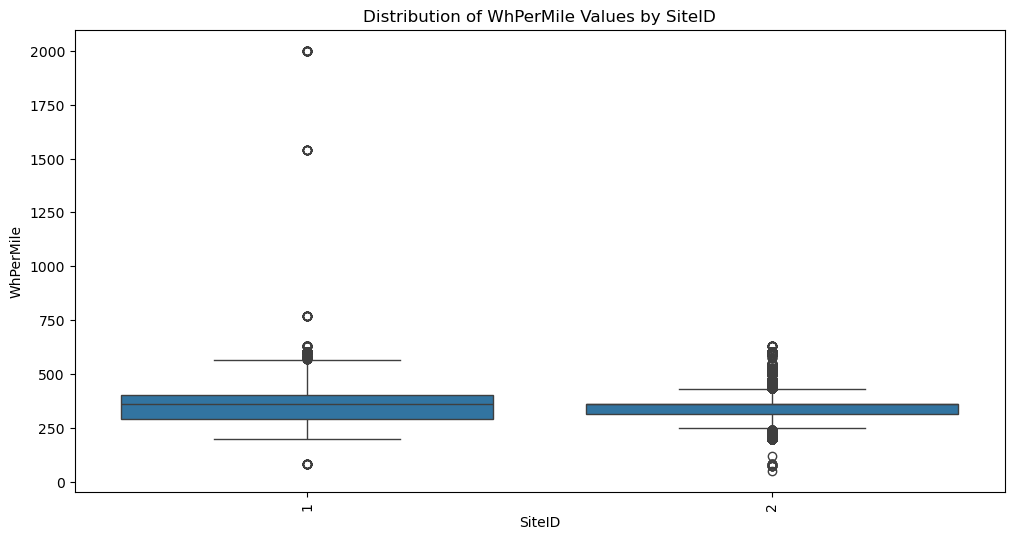

In [263]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='siteID', y='userInputs_WhPerMile', data=charging)
plt.title('Distribution of WhPerMile Values by SiteID')
plt.xticks(rotation=90)
plt.xlabel('SiteID')
plt.ylabel('WhPerMile')
plt.show()

<b> Site 1 more efficient cars -> more expensive cars?

## kWhRequested vs actual kWhDelivered

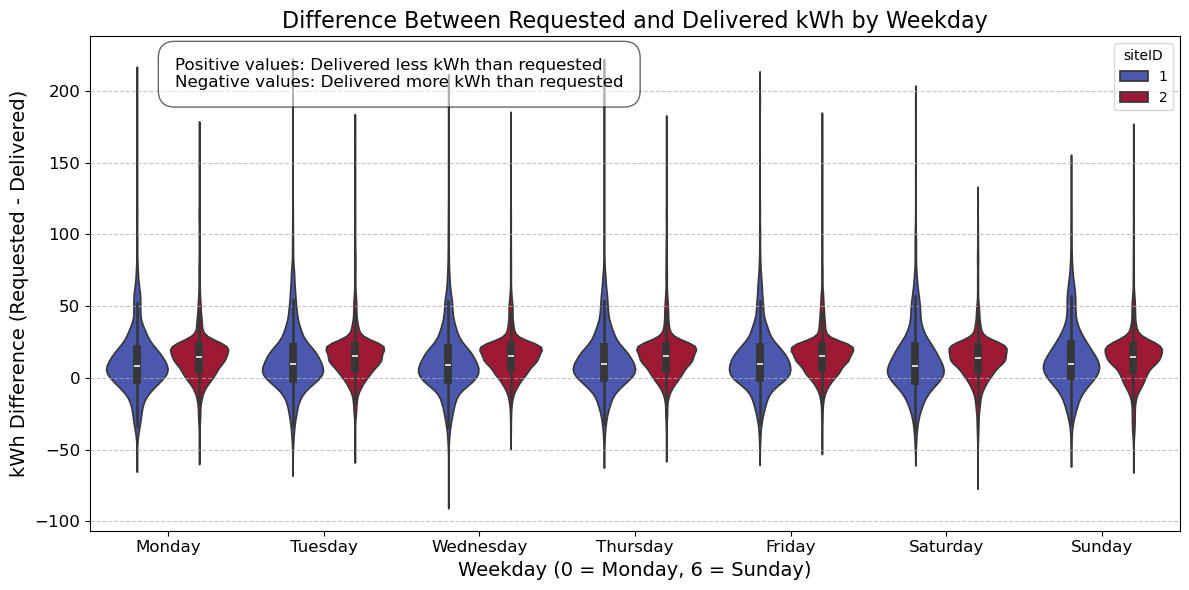

In [264]:
# Calculate idle time (in minutes)
charging['kWhDiscrepancy'] = (charging['userInputs_kWhRequested'] - charging['kWhDelivered'])

# Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.violinplot(data=charging, x='weekday', y='kWhDiscrepancy', palette='coolwarm', hue='siteID')

# Customize the plot
plt.title('Difference Between Requested and Delivered kWh by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('kWh Difference (Requested - Delivered)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend or annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Delivered less kWh than requested\nNegative values: Delivered more kWh than requested', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Tight layout to prevent clipping
plt.tight_layout()
plt.show()

## requested Departure vs actual Departure (DisconnectTime)

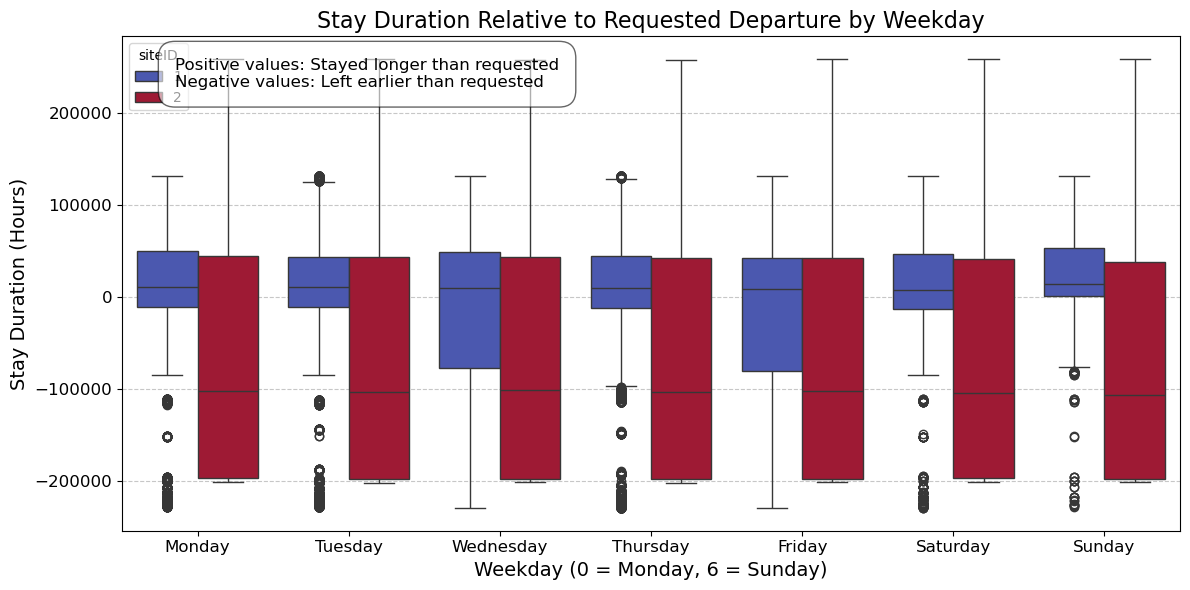

In [265]:
# Convert 'userInputs_requestedDeparture' to datetime with the correct format
charging['requestedDeparture'] = pd.to_datetime(charging['userInputs_requestedDeparture']).dt.tz_localize('UTC')

# Ensure 'disconnectTime' is also timezone-aware in UTC
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_convert('UTC')

charging['stay_duration'] = (charging['disconnectTime'] - charging['requestedDeparture']).dt.total_seconds() / 360  # Convert to hours

# Step 2: Plot the data using a violin plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID')

# Step 3: Customize the plot
plt.title('Stay Duration Relative to Requested Departure by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Step 4: Add a custom annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than requested\nNegative values: Left earlier than requested', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Step 5: Tight layout to prevent clipping
plt.tight_layout()
plt.show()

In [266]:
charging.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,weekday,time_of_day,hourly_range,year,month,idle_time_minutes,idle_time_hours,kWhDiscrepancy,requestedDeparture,stay_duration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194,...,3,Noon,"DatetimeIndex(['2020-01-02 13:00:00+00:00', '2...",2020,1,99.666667,1.661111,-0.016,2020-01-02 20:51:54+00:00,-16.775000
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275,...,3,Noon,"DatetimeIndex(['2020-01-02 13:00:00+00:00', '2...",2020,1,140.266667,2.337778,36.903,2020-01-02 23:31:50+00:00,-8.913889
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344,...,3,Noon,"DatetimeIndex(['2020-01-02 13:00:00+00:00', '2...",2020,1,484.266667,8.071111,1.479,2020-01-02 14:56:35+00:00,97.130556
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117,...,3,Noon,"DatetimeIndex(['2020-01-02 13:00:00+00:00', '2...",2020,1,79.900000,1.331667,5.645,2020-01-02 15:04:58+00:00,15.613889
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334,...,3,Noon,"DatetimeIndex(['2020-01-02 14:00:00+00:00', '2...",2020,1,231.166667,3.852778,-5.375,2020-01-02 15:04:58+00:00,70.616667


In [267]:
(charging['disconnectTime'] - charging['requestedDeparture']).dt.total_seconds()

0           -6039.0
1           -3209.0
2           34967.0
3            5621.0
4           25422.0
            ...    
63619    19799267.0
63620    19800468.0
63621    19782350.0
63622    19789299.0
63623    19795245.0
Length: 63624, dtype: float64

In [268]:
charging['stay_duration'].max()

258531.52222222224

In [269]:
# Find the index of the maximum kWhDiscrepancy
max_discrepancy_index = charging['kWhDiscrepancy'].idxmax()

# Retrieve the row with the highest discrepancy
max_discrepancy_row = charging.loc[max_discrepancy_index]

max_discrepancy_row.id


'5c7ee8e3f9af8b1308c33a54'

In [270]:
charging[charging['id'] == '5c7ee8e3f9af8b1308c33a54']

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,weekday,time_of_day,hourly_range,year,month,idle_time_minutes,idle_time_hours,kWhDiscrepancy,requestedDeparture,stay_duration
55927,5c7ee8e3f9af8b1308c33a54,2019-01-24 14:36:03+00:00,2019-01-24 23:36:20+00:00,2019-01-24 15:07:16+00:00,0.842,1_1_179_800_2019-01-24 14:36:03.232399,1,AG-3F32,1-1-179-800,0,...,3,Noon,"DatetimeIndex(['2019-01-24 14:00:00+00:00', '2...",2019,1,509.066667,8.484444,214.478,2021-08-28 01:52:56+00:00,-227062.766667


<b> user input modified 2 years later und requested departure is also set 2 years later?! -> Maybe requested departure not usable because of this

## User estimated minutesAvailable vs Actual minutes (disconnect - connect Time)

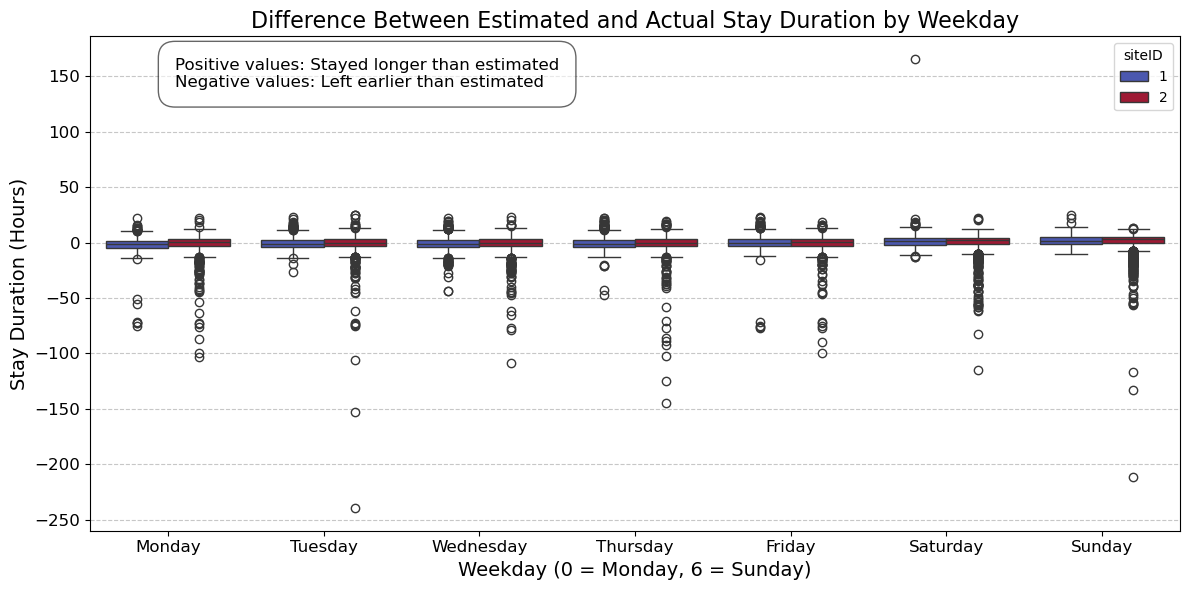

In [271]:
# Step 1: Ensure 'disconnectTime' is also timezone-aware in UTC
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_convert('UTC')

charging['stay_duration'] = (charging['userInputs_minutesAvailable'] - ((charging['disconnectTime'] - charging['connectionTime']).dt.total_seconds() / 60)) / 60

# Step 2: Plot the data using a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID')

# Step 3: Customize the plot
plt.title('Difference Between Estimated and Actual Stay Duration by Weekday', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Add a custom annotation for positive and negative values
plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than estimated\nNegative values: Left earlier than estimated', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

# Step 5: Tight layout to prevent clipping
plt.tight_layout()
plt.show()


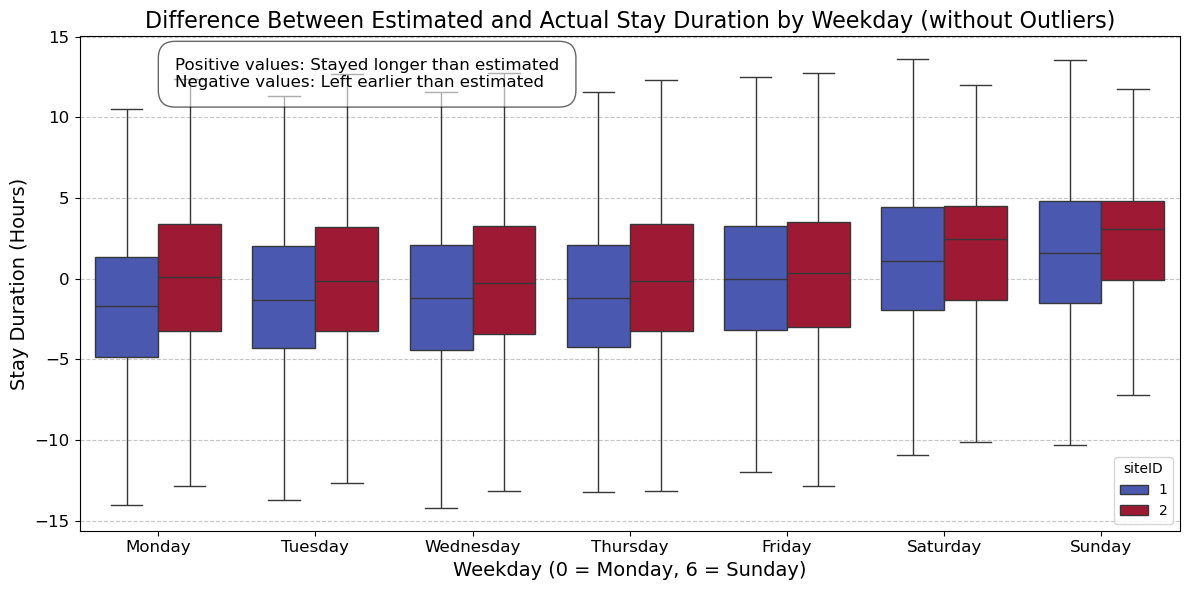

In [272]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=charging, x='weekday', y='stay_duration', palette='coolwarm', hue='siteID', showfliers=False)

plt.title('Difference Between Estimated and Actual Stay Duration by Weekday (without Outliers)', fontsize=16)
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Stay Duration (Hours)', fontsize=14)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.figtext(0.15, 0.85, 'Positive values: Stayed longer than estimated\nNegative values: Left earlier than estimated', 
            wrap=True, horizontalalignment='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=1'))

plt.tight_layout()
plt.show()


# Weather

In [273]:
weather.head(15)

,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0
5,2018-01-01 13:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0
6,2018-01-01 14:53:00,7.0,30.0,Partly Cloudy,992.08,0.0,0.0,7.0
7,2018-01-01 15:53:00,8.0,34.0,Fair,992.41,0.0,0.0,8.0
8,2018-01-01 16:53:00,12.0,34.0,Fair,993.39,0.0,0.0,12.0
9,2018-01-01 17:53:00,16.0,34.0,Fair,994.05,0.0,0.0,16.0


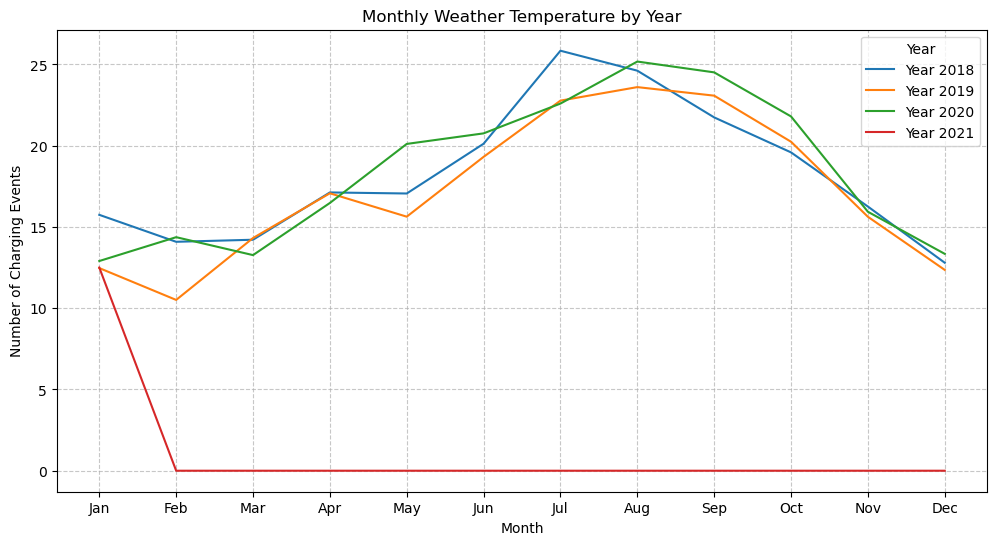

In [274]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['temperature'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Temperature by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

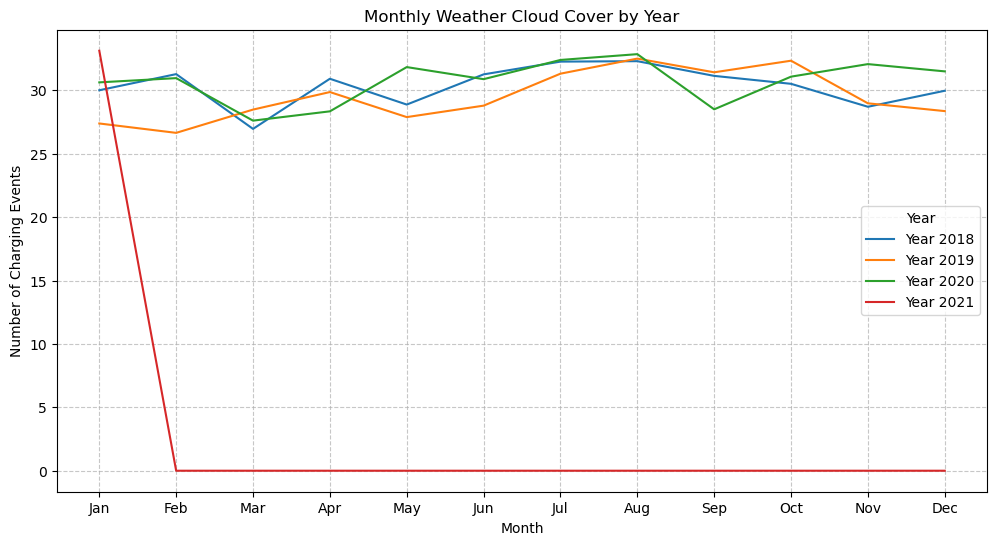

In [275]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['cloud_cover'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Cloud Cover by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

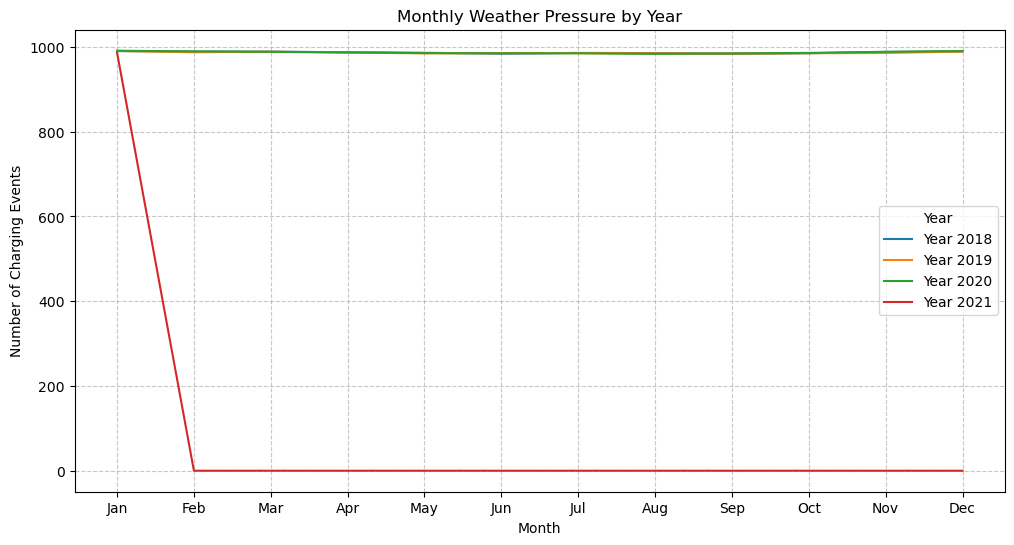

In [276]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['pressure'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Weather Pressure by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

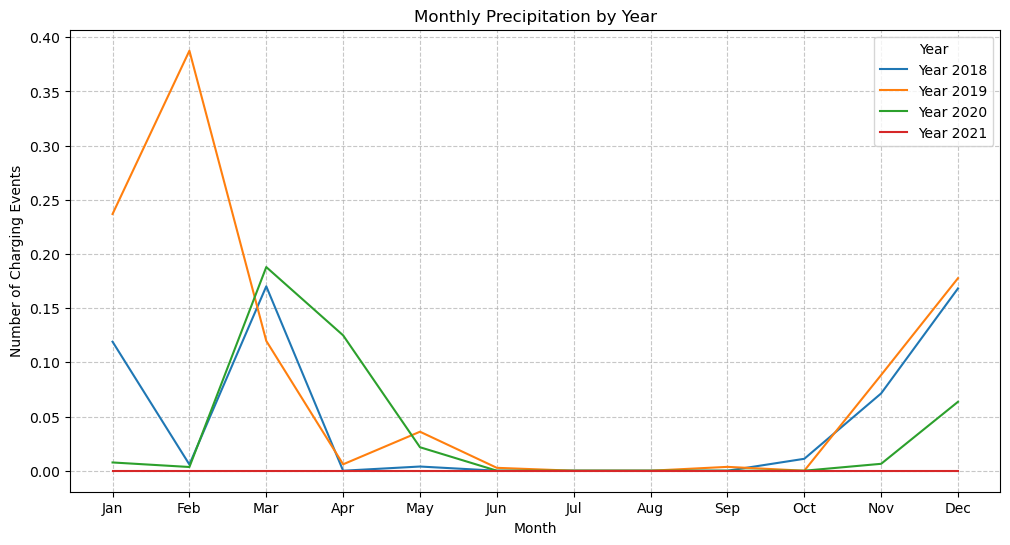

In [277]:
weather['year'] = weather['timestamp'].dt.year
weather['month'] = weather['timestamp'].dt.month

yearly_monthly_counts = weather.groupby(['year', 'month'])['precipitation'].mean().unstack(fill_value=0)
yearly_monthly_counts
plt.figure(figsize=(12, 6))
for year in yearly_monthly_counts.index:
    plt.plot(yearly_monthly_counts.columns, yearly_monthly_counts.loc[year], label=f"Year {year}")

# Add labels, title, and legend
plt.title("Monthly Precipitation by Year")
plt.xlabel("Month")
plt.ylabel("Number of Charging Events")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<h2> Show plot with x from 2018 to 2021 for seasonality </h2>

<h2> Idea: konfidenzintervall </h2>

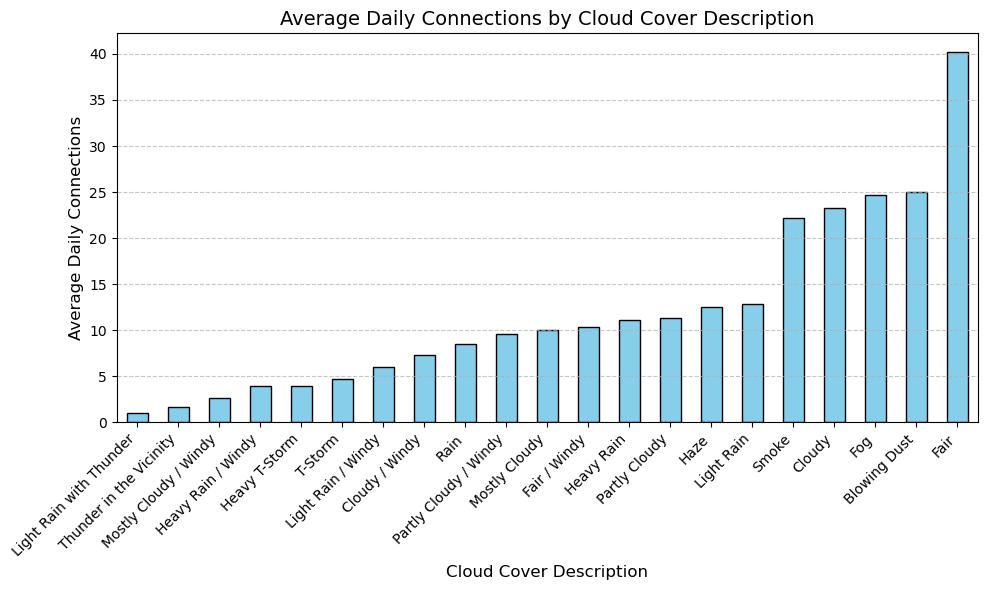

In [278]:
# Convert `timestamp` in `weather` to UTC to match `connectionTime`
weather['timestamp'] = weather['timestamp'].dt.tz_localize('UTC')

# Merge charging and weather data on the nearest time
merged_data = pd.merge_asof(
    charging.sort_values('connectionTime'),
    weather.sort_values('timestamp'),
    left_on='connectionTime',
    right_on='timestamp',
    direction='backward'
)

# Extract the date part for daily aggregation
merged_data['date'] = merged_data['connectionTime'].dt.date

# Group by date and cloud description, count connections
daily_connections = merged_data.groupby(['date', 'cloud_cover_description']).size().reset_index(name='connections')

# Calculate the average daily connections for each cloud description
avg_daily_connections = daily_connections.groupby('cloud_cover_description')['connections'].mean()

# Plot the bar chart
plt.figure(figsize=(10, 6))
avg_daily_connections.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels, title, and grid
plt.title("Average Daily Connections by Cloud Cover Description", fontsize=14)
plt.xlabel("Cloud Cover Description", fontsize=12)
plt.ylabel("Average Daily Connections", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

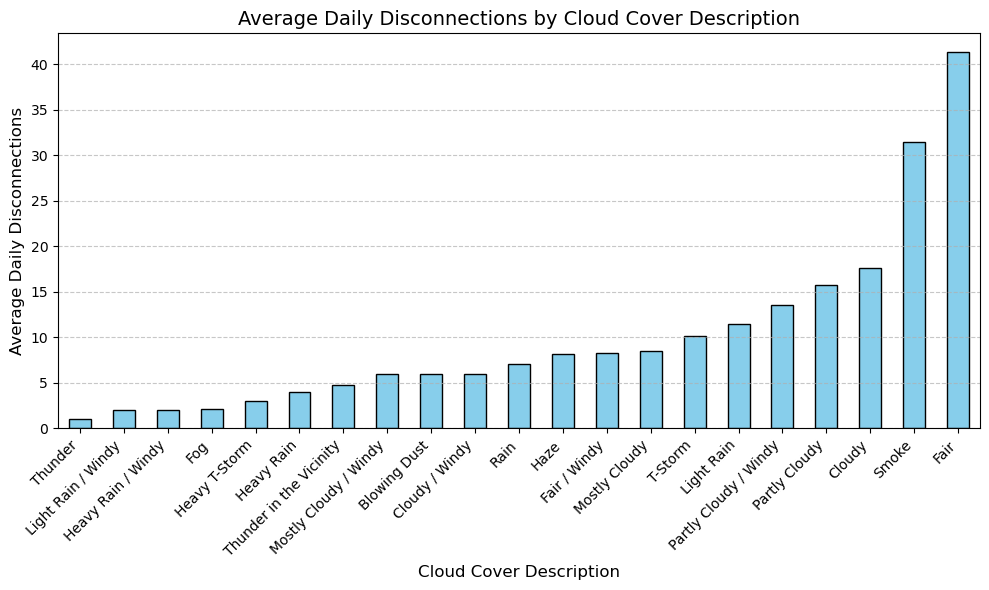

In [279]:
# Merge charging and weather data on the nearest time
merged_data = pd.merge_asof(
    charging.sort_values('disconnectTime'),
    weather.sort_values('timestamp'),
    left_on='disconnectTime',
    right_on='timestamp',
    direction='backward'
)

# Extract the date part for daily aggregation
merged_data['date'] = merged_data['disconnectTime'].dt.date

# Group by date and cloud description, count connections
daily_disconnections = merged_data.groupby(['date', 'cloud_cover_description']).size().reset_index(name='connections')

# Calculate the average daily connections for each cloud description
avg_daily_disconnections = daily_disconnections.groupby('cloud_cover_description')['connections'].mean()

# Plot the bar chart
plt.figure(figsize=(10, 6))
avg_daily_disconnections.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels, title, and grid
plt.title("Average Daily Disconnections by Cloud Cover Description", fontsize=14)
plt.xlabel("Cloud Cover Description", fontsize=12)
plt.ylabel("Average Daily Disconnections", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

<h4>Interpretation</h4>

We see multiple things:

1. 2018 and 2019 had more sessions than the other years -> In year 2020 pandemic started and this could have resulted in a reduction commuting and traveling, reduction imports for material for these vehicles ect. so the use of e-vehicles also decreased from 2020 on

2. **Some month are not recorded in the data, such as the first three months of 2018 and the last 3 months of 2021 and september + october of 2020 -> why?**

3. In year 2020, the demand significantly went down from april on and stayed on a very low level for the rest of the year -> can be attributed to covid

4. In year 2021, chargign sessions went up again -> "recovery" from covid, restrictions weren't that strict anymore

# Usage station specific

In [280]:
charging_stations = charging.groupby('siteID')['stationID'].nunique()
charging_stations

siteID
1    52
2    55
Name: stationID, dtype: int64

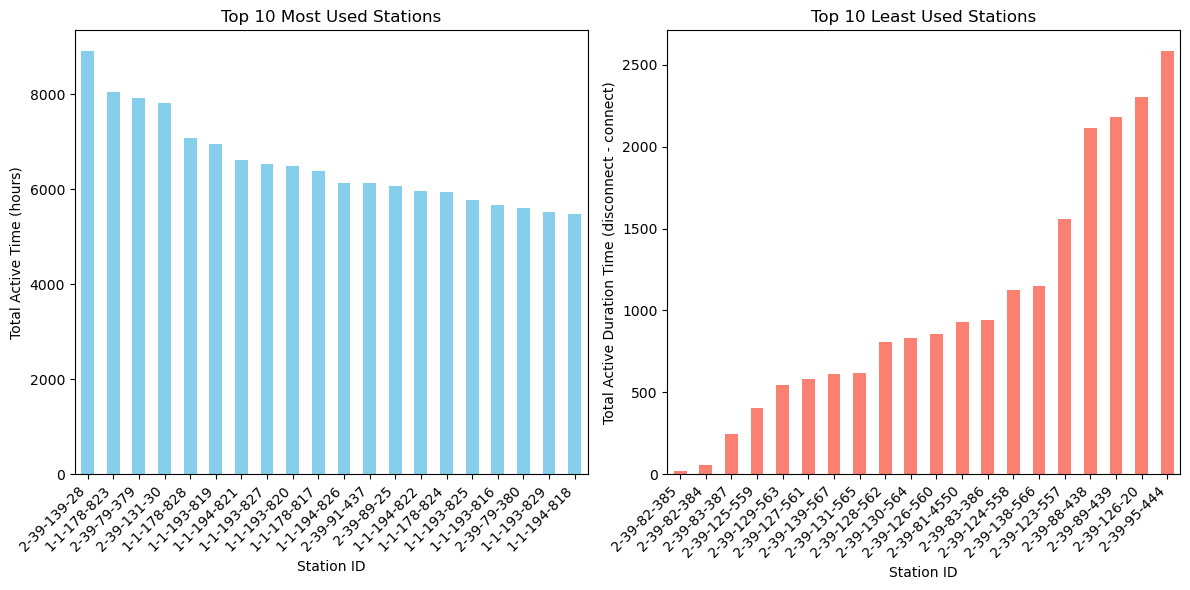

In [281]:
charging['duration'] = (charging['disconnectTime'] - charging['connectionTime']).dt.total_seconds() / 3600

station_active_time = charging.groupby('stationID')['duration'].sum()

most_used_stations = station_active_time.sort_values(ascending=False).head(20)

most_unused_stations = station_active_time.sort_values(ascending=True).head(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
most_used_stations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Time (hours)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
most_unused_stations.plot(kind='bar', color='salmon')
plt.title('Top 10 Least Used Stations')
plt.xlabel('Station ID')
plt.ylabel('Total Active Duration Time (disconnect - connect)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


<h2> Show duration time for all Stations -> only one plot per site, different colors for each site</h2>

As we can see, stations of site 1 are much more used than stations of site 2 -> indication that site 2 might be the private site

# Task 2 b.) - KPI

<h2> Task

<h2>First KPI: Idle Time </h2>

This insight into the efficiency and utilization of charging stations. By monitoring the time between when charging is complete and when the vehicle is unplugged, operators can assess whether resources are being optimally used.

idle_time_bins
0-1 hour       30218
1-2 hours       5750
2-3 hours       4695
3-4 hours       4194
4-5 hours       4240
5-6 hours       4163
6-7 hours       3816
7-8 hours       2863
8-9 hours       1777
9-10 hours       799
10-11 hours      313
11-12 hours      198
12-13 hours      112
13-14 hours       75
14-15 hours       48
15-16 hours       45
16-17 hours       23
17-18 hours       20
18-19 hours       21
19-20 hours       14
20-21 hours       16
21-22 hours       40
22-23 hours       18
23-24 hours       17
24+ hours        149
Name: count, dtype: int64


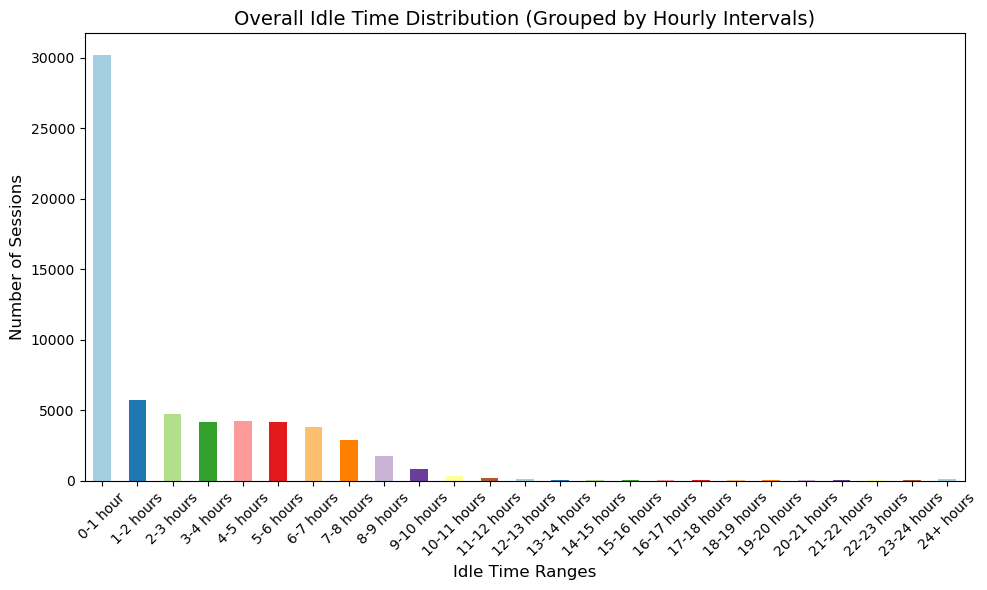

In [289]:
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['idle_time'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 3600

charging['idle_time'] = charging['idle_time'].apply(lambda x: max(x, 0))

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, float('inf')]
labels = ['0-1 hour', '1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours', '5-6 hours', '6-7 hours', '7-8 hours', '8-9 hours', 
          '9-10 hours', '10-11 hours', '11-12 hours', '12-13 hours', '13-14 hours', '14-15 hours', '15-16 hours', 
          '16-17 hours', '17-18 hours', '18-19 hours', '19-20 hours', '20-21 hours', '21-22 hours', '22-23 hours', 
          '23-24 hours', '24+ hours']

charging['idle_time_bins'] = pd.cut(charging['idle_time'], bins=bins, labels=labels, right=False)

idle_time_distribution = charging['idle_time_bins'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
idle_time_distribution.plot(kind='bar', color=plt.cm.Paired.colors)
plt.title('Overall Idle Time Distribution (Grouped by Hourly Intervals)', fontsize=14)
plt.xlabel('Idle Time Ranges', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\luan0\AppData\Local\Temp\ipykernel_10520\2571149967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_after_full_charge['disconnect_hour'] = charging_after_full_charge['disconnectTime'].dt.hour


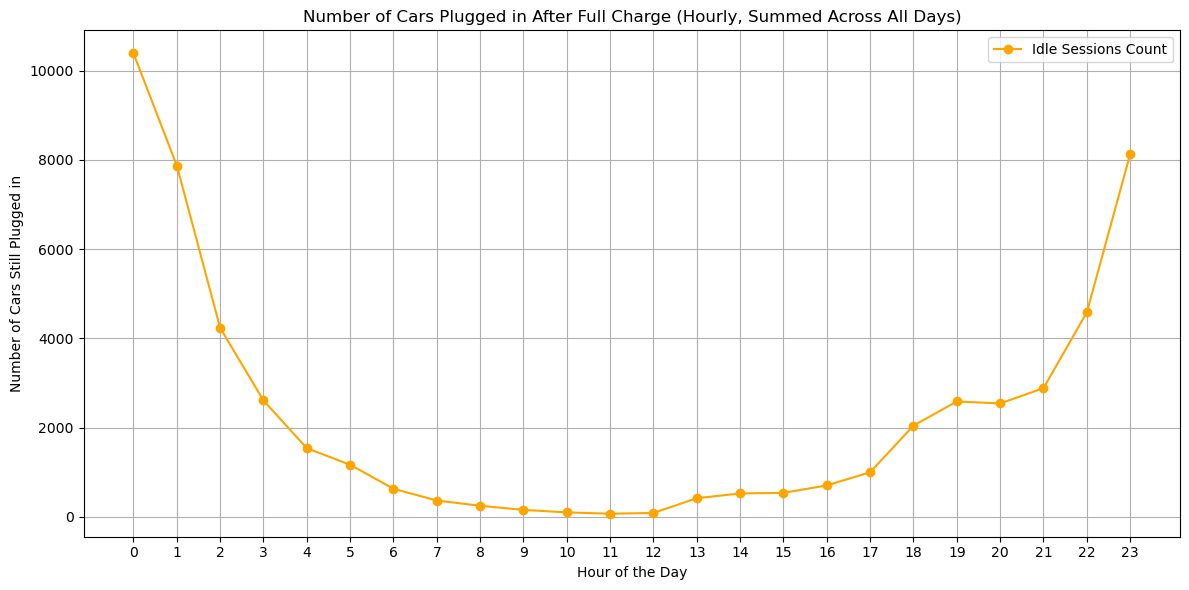

In [ ]:
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['idle_time'] = (charging['disconnectTime'] - charging['doneChargingTime']).dt.total_seconds() / 3600

charging['idle_time'] = charging['idle_time'].apply(lambda x: max(x, 0))

charging_after_full_charge = charging[charging['idle_time'] > 0]

charging_after_full_charge['disconnect_hour'] = charging_after_full_charge['disconnectTime'].dt.hour

hourly_idle_sessions = charging_after_full_charge.groupby('disconnect_hour').size()


plt.figure(figsize=(12, 6))
hourly_idle_sessions.plot(kind='line', color='orange', marker='o', label='Idle Sessions Count')
plt.title('Number of Cars Plugged in After Full Charge (Hourly, Summed Across All Days over all Years)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Cars Still Plugged in')
plt.xticks(range(0, 24, 1)) 
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


The high idle time during nights suggests that cars are staying plugged in after they’re fully charged, taking up valuable charging spots. 

To improve this, the hub operator could consider adding fees for cars that stay plugged in after they’re fully charged. Charging a small fee for idle time would encourage users to unplug their cars more quickly. This would help make better use of the charging stations, as people would be more likely to avoid the fee. The fee could be based on how long the car has been plugged in after charging is complete (e.g. 0 to 1 hour, 1 to 2 hours ect.), ensuring it’s fair while addressing the issue of idle cars. It would also free up spots for others and could generate some additional revenue for the hub.

<h2> Second KPI: Kwh Requested vs delivered </h2>

We chose this KPI to see how well the charging stations are meeting user expectations. By comparing the energy requsted by users with the energy delivered, we can quickly spot any gaps in sevrice. If users consistently ask for more energy than they get, it could signal issues like slow charging speeds, underpowered stations, or even problems with how users estimate their needs.

For the business owner, this is important because if there's a big difference between requested and delivered energy, it might mean customers aren’t getting what they expect, which can lead to frustration and potentially fewer users. By tracking this, the hub operator can make improvements, like upgrading equipment or adjusting operations, to better serve customers and increase station usage.

From the data, it’s clear that users almost always request more energy than they actually receive. This points to possible inefficiencies in the system or misestimations by users. For the operator, addressing this could lead to better customer experiences and a more efficient use of resources.

To improve the gap between requested and delivered energy, the operator should consider upgrading the charging infrastructure to handle higher energy demands and optimizing charging speeds to ensure users receive the energy they requested. This would enhance customer satisfaction and increase the efficiency of the charging hubs.

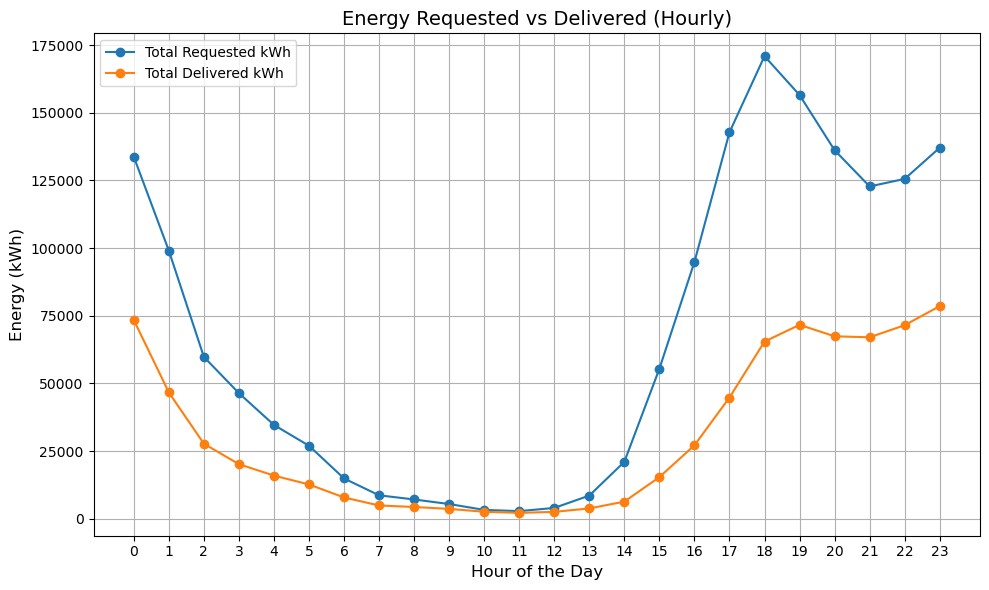

In [302]:
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

# Extract hour from 'doneChargingTime'
charging['hour'] = charging['doneChargingTime'].dt.hour

# Group by hour and calculate the sum of 'userInputs_kWhRequested' and 'kWhDelivered' (assuming 'kWhDelivered' is the actual energy delivered column)
hourly_energy = charging.groupby('hour').agg(
    total_requested_kWh=('userInputs_kWhRequested', 'sum'),
    total_delivered_kWh=('kWhDelivered', 'sum')
).reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(hourly_energy['hour'], hourly_energy['total_requested_kWh'], label='Total Requested kWh', marker='o')
plt.plot(hourly_energy['hour'], hourly_energy['total_delivered_kWh'], label='Total Delivered kWh', marker='o')
plt.title('Energy Requested vs Delivered (Hourly)', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend()
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


# Task 2 c.) Site

Site 2 is probably the private site.

From the code above we can see that the top most unused stations are from site 2. we can assume that the private site is less used because it is not openly accessible. 

We can also see that Site 1 delivers much more energy than site 2, indicating that site 1 is more used 

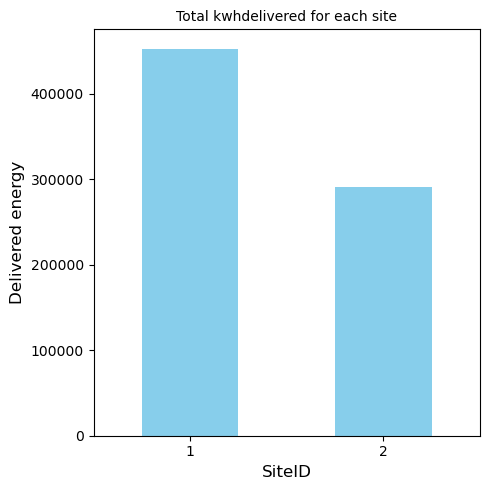

In [292]:
charging.head()
null_counts_per_site = charging.groupby('siteID')["kWhDelivered"].apply(lambda x: x.sum())
null_counts_per_site.plot(kind='bar', color='skyblue', figsize=(5, 5))

plt.title('Total kwhdelivered for each site', fontsize=10)
plt.ylabel('Delivered energy', fontsize=12)
plt.xlabel('SiteID', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

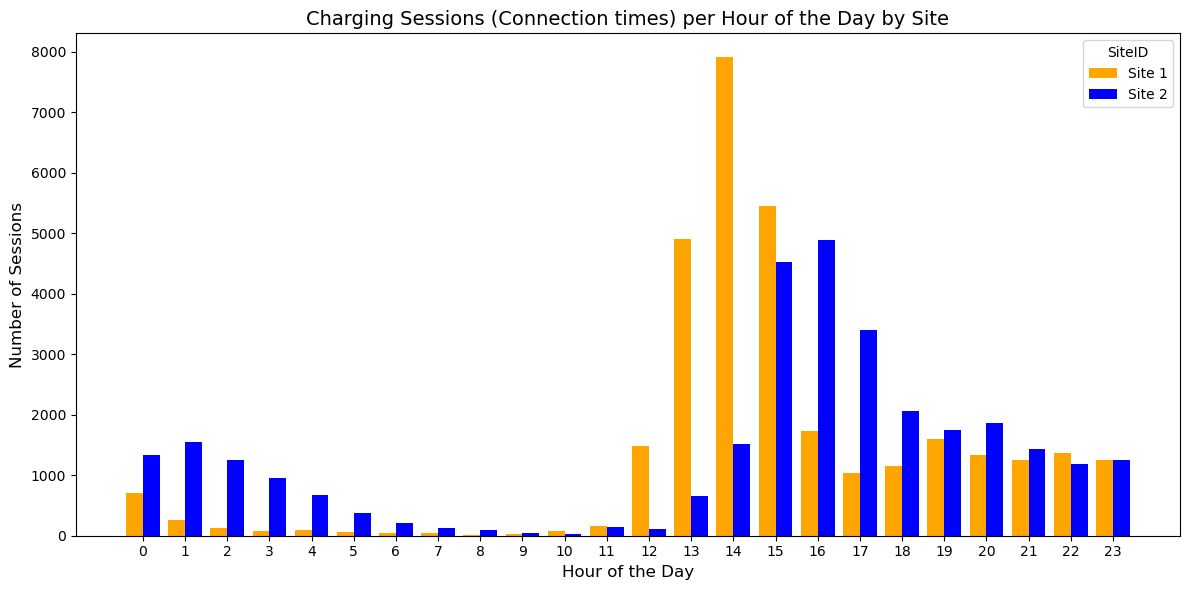

In [293]:
# Group by hour_of_day of connection time and siteID
sessions_per_hour_site = charging.groupby(['hour_of_day', 'siteID']).size().unstack(fill_value=0)

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.4

# Create x positions for bars
x = np.arange(24)

# Plot bars for each siteID
plt.bar(x - bar_width / 2, sessions_per_hour_site[1], width=bar_width, label='Site 1', color='orange')
plt.bar(x + bar_width / 2, sessions_per_hour_site[2], width=bar_width, label='Site 2', color='blue')

# Add labels and title
plt.xticks(range(0, 24), range(0, 24), rotation=0)
plt.title('Charging Sessions (Connection times) per Hour of the Day by Site', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

# Add a legend
plt.legend(title='SiteID')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

C:\Users\luan0\AppData\Local\Temp\ipykernel_10520\723593695.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_users_per_site.index, y=unique_users_per_site.values, palette="viridis")


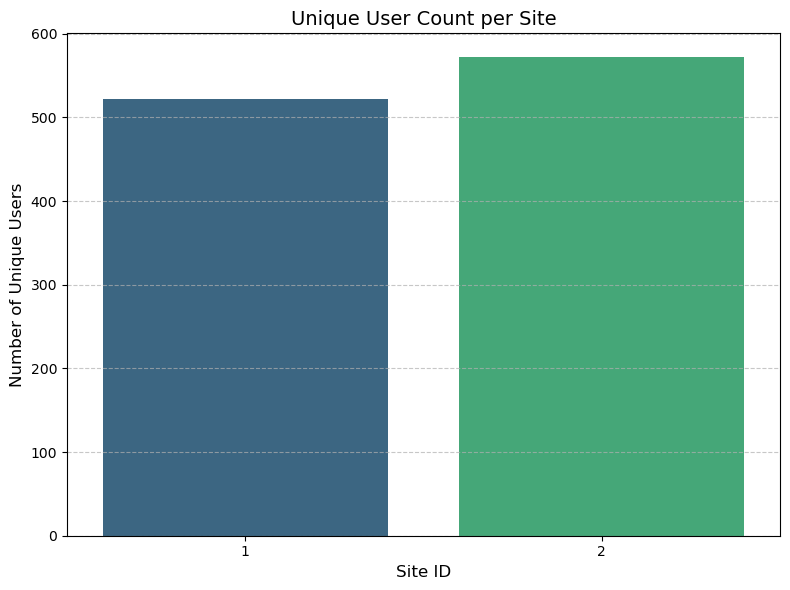

In [294]:
# Group by siteID and count unique userIDs
unique_users_per_site = charging.groupby('siteID')['userID'].nunique()

# Plot the result
plt.figure(figsize=(8, 6))
sns.barplot(x=unique_users_per_site.index, y=unique_users_per_site.values, palette="viridis")

# Customize the plot
plt.title('Unique User Count per Site', fontsize=14)
plt.xlabel('Site ID', fontsize=12)
plt.ylabel('Number of Unique Users', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()